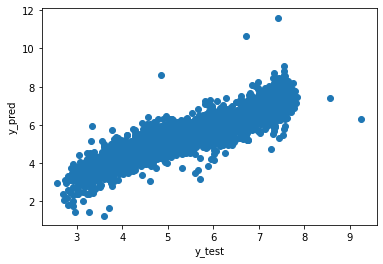

In [2]:
import numpy as np
import matplotlib.pyplot as plt
y_test = np.loadtxt("y_test.txt", dtype=float)
y_pred = np.loadtxt("y_pred.txt", dtype=float)
plt.scatter(y_test, y_pred)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.show()

In [ ]:
# 读取文件1.txt中的数字
with open('1.txt', 'r') as f:
    numbers1 = [float(num) for num in f.read().split()]

# 读取文件2.txt中的数字
with open('2.txt', 'r') as f:
    numbers2 = [float(num) for num in f.read().split()]

# 输出读取到的数字
print('Numbers in file 1:', numbers1)
print('Numbers in file 2:', numbers2)

In [10]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=21, padding=0),
            nn.BatchNorm1d(16),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=19, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=17, padding=0),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )
        self.fc = nn.Linear(38080, 1)  # 8960 ,17920
        self.drop = nn.Dropout(0.2)

    def forward(self, out):
        out = self.conv1(out)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)
        # print(out.size(1))
        out = self.fc(out)
        return out


class AlexNet(nn.Module):
    def __init__(self, num_classes=1, reduction=16):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=16),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv2
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=32),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv3
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv4
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=128),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # conv5
            nn.Conv1d(128, 192, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(num_features=192),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2, stride=2),
            # SELayer(256, reduction),
            # nn.LeakyReLU(inplace=True),
        )
        self.reg = nn.Sequential(
            nn.Linear(3840, 1000),  # 根据自己数据集修改
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.Linear(1000, 500),
            nn.ReLU(inplace=True),
            # nn.LeakyReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(500, num_classes),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.flatten(start_dim=1)
        out = self.reg(out)
        return out


class Inception(nn.Module):
    def __init__(self, in_c, c1, c2, c3, out_C):
        super(Inception, self).__init__()
        self.p1 = nn.Sequential(
            nn.Conv1d(in_c, c1, kernel_size=1, padding=0),
            nn.Conv1d(c1, c1, kernel_size=3, padding=1)
        )
        self.p2 = nn.Sequential(
            nn.Conv1d(in_c, c2, kernel_size=1, padding=0),
            nn.Conv1d(c2, c2, kernel_size=5, padding=2)

        )
        self.p3 = nn.Sequential(
            nn.MaxPool1d(kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_c, c3, kernel_size=3, padding=1),
        )
        self.conv_linear = nn.Conv1d((c1 + c2 + c3), out_C, 1, 1, 0, bias=True)
        self.short_cut = nn.Sequential()
        if in_c != out_C:
            self.short_cut = nn.Sequential(
                nn.Conv1d(in_c, out_C, 1, 1, 0, bias=False),

            )

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(x)
        p3 = self.p3(x)
        out = torch.cat((p1, p2, p3), dim=1)
        out += self.short_cut(x)
        return out


class DeepSpectra(nn.Module):
    def __init__(self):
        super(DeepSpectra, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=3, padding=0)
        )
        self.Inception = Inception(16, 32, 32, 32, 96)
        self.fc = nn.Sequential(
            nn.Linear(20640, 5000),
            nn.Dropout(0.5),
            nn.Linear(5000, 1)
        )
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.Inception(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


class SpectraCNN(nn.Module):
    """
    实例化模型
    model = SpectraCNN()

    损失函数和优化器
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

    训练模型
    for epoch in range(EPOCH):
        for data in train_loader:
            inputs, labels = data
            inputs = inputs.unsqueeze(1) # 增加一维，因为CNN输入需要4维
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    # 每个epoch结束后输出loss
    print("Epoch: {}, Loss: {:.4f}".format(epoch+1, loss.item()))

    测试模型
    with torch.no_grad():
        correct = 0
        total = 0
        for data in test_loader:
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print("Accuracy: {:.2f}%".format(100 * correct / total))
    """
    def __init__(self):
        super(SpectraCNN, self).__init__()

        # Input layer
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        self.dropout1 = nn.Dropout(p=0.25)

        # Hidden layer 1
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(p=0.25)

        # Hidden layer 2
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2)
        self.dropout3 = nn.Dropout(p=0.25)

        # Output layer
        self.fc = nn.Linear(in_features=5184, out_features=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x



NameError: name 'nn' is not defined